# Importing the necessary libraries

In [339]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import Sequential, layers

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import os
import pandas as pd
import numpy as np


In [341]:
import glob
import os
import PIL
import time
import cv2
from tensorflow.keras.utils import to_categorical
from IPython import display

In [342]:
labels = ['MalwareA', 'MalwareB','MalwareC', 'MalwareD','MalwareE']
img_size = 128
def get_training_data(data_dir):
    X = [] 
    Y = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = pd.read_csv(os.path.join(path, img), header=None, index_col=None).to_numpy()
                X.append(img_arr)
                Y.append(class_num)
            except Exception as e:
                print(e)
    return np.array(X),np.array(Y)

# Loading the Dataset

In [343]:
X,Y = get_training_data('/content/drive/MyDrive/CS_271/CS_271/final_images/')

# Data Visualization & Preprocessing

In [344]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42, shuffle=True)

In [345]:
#x_val,x_test,y_val,y_test = train_test_split(x_rem,y_rem,test_size=0.5, random_state=42, shuffle=True)

In [346]:
print(x_train.shape,y_train.shape)

(4000, 128, 128) (4000,)


In [347]:
np.random.seed(42)
trainsize = 2000  # number of training images we use, selected randomly
randtrain = np.random.choice(x_train.shape[0], trainsize, replace=False)
train_images, train_labels = x_train[randtrain], y_train[randtrain]

print(train_images.shape, train_labels.shape)

(2000, 128, 128) (2000,)


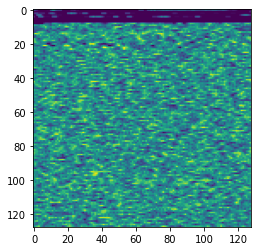

In [348]:
plt.figure()
plt.imshow(train_images[7])
plt.imshow(train_images[7])
plt.show()

In [350]:
train_images = train_images.reshape(train_images.shape[0], 128, 128).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [351]:
import tensorflow as tf

BUFFER_SIZE = trainsize
BATCH_SIZE = 100
g_loss = []
d_loss = []

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [352]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(1 , (2,2) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #model.add(layers.Reshape((14, 14, 256)))
    #assert model.output_shape == (None, 14, 14, 256) # Note: None is the batch size

    model.add(layers.Conv2D(1,(2,2), strides= 1, padding='same', activation = 'relu', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (2, 2), strides=1, padding='same', activation = 'relu', use_bias=False))
    #assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 64, 64, 128)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 128, 128, 64)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (2, 2), strides= 1, padding='same', activation = 'relu', use_bias=False))
    #assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1,(1,1) , strides=1, padding='same', use_bias=False, activation='tanh'))

    #model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 28, 28, 3)
    model.summary()

    return model

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270 (Conv2D)         (None, 128, 128, 1)       5         
                                                                 
 batch_normalization_242 (Ba  (None, 128, 128, 1)      4         
 tchNormalization)                                               
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 128, 128, 1)       0         
                                                                 
 conv2d_271 (Conv2D)         (None, 128, 128, 1)       4         
                                                                 
 batch_normalization_243 (Ba  (None, 128, 128, 1)      4         
 tchNormalization)                                               
                                                                 
 conv2d_272 (Conv2D)         (None, 128, 128, 1)     

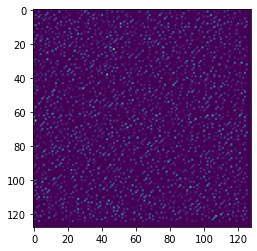

In [353]:
generator = make_generator_model()

noise = tf.random.normal([1, 128, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0])
plt.show()

In [303]:
'''def make_discriminator_model():
  model = Sequential()
  model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
  #model.add(Dropout(0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #--
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #--
  model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
  model.add(Flatten())
  model.add(Dense(units = 128 , activation = 'relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))
  model.compile(loss="sparse_categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
  model.summary()

  return model'''

'def make_discriminator_model():\n  model = Sequential()\n  model.add(Conv2D(32 , (5,5) , strides = 1 , padding = \'same\' , activation = \'relu\' , input_shape = (128,128,1)))\n  model.add(BatchNormalization())\n  model.add(MaxPool2D((2,2) , strides = 2 , padding = \'same\'))\n  model.add(Conv2D(32 , (5,5) , strides = 1 , padding = \'same\' , activation = \'relu\'))\n  #model.add(Dropout(0.1))\n  model.add(BatchNormalization())\n  model.add(MaxPool2D((2,2) , strides = 2 , padding = \'same\'))\n  model.add(Conv2D(64 , (3,3) , strides = 1 , padding = \'same\' , activation = \'relu\'))\n  model.add(BatchNormalization())\n  model.add(MaxPool2D((2,2) , strides = 2 , padding = \'same\'))\n  model.add(Conv2D(128 , (3,3) , strides = 1 , padding = \'same\' , activation = \'relu\'))\n  #model.add(Dropout(0.2))\n  model.add(BatchNormalization())\n  model.add(MaxPool2D((2,2) , strides = 2 , padding = \'same\'))\n  model.add(Conv2D(256 , (3,3) , strides = 1 , padding = \'same\' , activation = \'re

In [376]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(1, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(5))

    model.summary()
    return model

In [377]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_281 (Conv2D)         (None, 128, 128, 64)      1664      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_282 (Conv2D)         (None, 128, 128, 1)       1601      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 128, 128, 1)       0         
                                                                 
 flatten_37 (Flatten)        (None, 16384)             0         
                                                                 
 dense_75 (Dense)            (None, 5)                 81925     
                                                                 
Total params: 85,190
Trainable params: 85,190
Non-tra

In [378]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [379]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss


In [380]:
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss

In [381]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [382]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [383]:
EPOCHS = 50
noise_dim = 128
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim,noise_dim])

In [384]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, g_loss)
      disc_loss = discriminator_loss(real_output, fake_output, d_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6,6))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

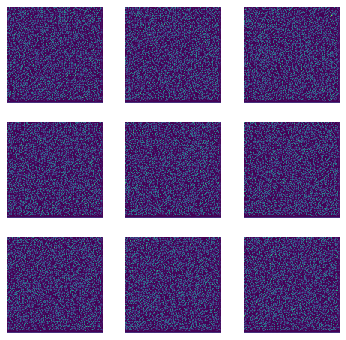

In [385]:
train(train_dataset, EPOCHS)

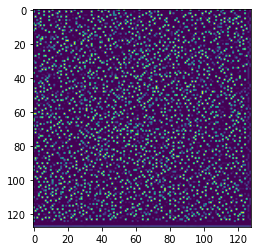

In [386]:
noi = tf.random.normal([1, 128,128])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0])

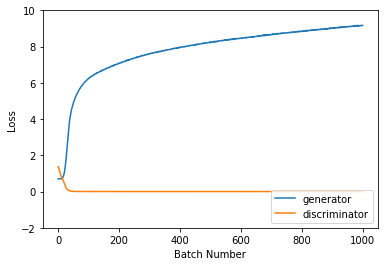

In [387]:
plt.figure()
plt.plot(g_loss, label='generator')
plt.plot(d_loss, label = 'discriminator')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.ylim([-2, 10])
plt.legend(loc='lower right')
plt.show()

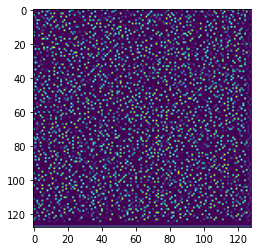

In [388]:
noi = tf.random.normal([1, 128,128])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0])

In [389]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))





In [390]:
disc = checkpoint.discriminator
disc.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_281 (Conv2D)         (None, 128, 128, 64)      1664      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_282 (Conv2D)         (None, 128, 128, 1)       1601      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 128, 128, 1)       0         
                                                                 
 flatten_37 (Flatten)        (None, 16384)             0         
                                                                 
 dense_75 (Dense)            (None, 5)                 81925     
                                                                 
Total params: 85,190
Trainable params: 85,190
Non-tra

In [391]:
val = disc(sample)
print (val)


tf.Tensor([[-7.59399  -7.636189 -7.506601 -7.655556 -7.237411]], shape=(1, 5), dtype=float32)


In [392]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(5, activation='softmax'))
new_model.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_281 (Conv2D)         (None, 128, 128, 64)      1664      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_282 (Conv2D)         (None, 128, 128, 1)       1601      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 128, 128, 1)       0         
                                                                 
 flatten_37 (Flatten)        (None, 16384)             0         
                                                                 
 dense_76 (Dense)            (None, 5)                 81925     
                                                                 
Total params: 85,190
Trainable params: 81,925
Non-tra

In [393]:
new_model.layers[-1].weights

[<tf.Variable 'dense_76/kernel:0' shape=(16384, 5) dtype=float32, numpy=
 array([[-0.01511168,  0.01617532, -0.00402674, -0.00760321, -0.004711  ],
        [ 0.00790486,  0.01348504, -0.01744146, -0.00558837, -0.00547915],
        [ 0.01877852,  0.00454164, -0.01835243,  0.0097774 , -0.01718882],
        ...,
        [ 0.0062087 ,  0.00993628, -0.01856575,  0.00415816, -0.01822884],
        [ 0.01091187,  0.01335287, -0.00491815, -0.01026629, -0.01301413],
        [-0.00282793, -0.01365017,  0.00240851,  0.00546085, -0.01171505]],
       dtype=float32)>,
 <tf.Variable 'dense_76/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>]

In [394]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, '\n')

np.random.seed(42)
trainsize = 2000  # number of training images we use, selected randomly
randtrain = np.random.choice(x_train.shape[0], trainsize, replace=False)
X_train, Y_train = x_train[randtrain], y_train[randtrain]

np.random.seed(33)
testsize = 500  # number of testing images we use, selected randomly
randtest = np.random.choice(x_test.shape[0], testsize, replace=False)
X_test, Y_test = x_test[randtest], y_test[randtest]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
#print(Y_train,Y_test)

(4000, 128, 128) (4000,) (1000, 128, 128) (1000,) 

(2000, 128, 128) (2000,) (500, 128, 128) (500,)


In [ ]:
train_images = X_train.reshape((trainsize, 128, 128, 1))
train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 128, 128, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(Y_train)

test_labels = to_categorical(Y_test)
#print(train_labels, test_labels)

print(test_labels[9])
#print(np.argmax(test_labels[9]))
#train_lables = train_labels.sort()
#test_labels = test_labels.sort()
#print(train_labels, test_labels)

new_model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = new_model.fit(train_images, train_labels, batch_size=100, epochs=500,
                        validation_data=(test_images, test_labels))

[1. 0. 0. 0. 0.]
Epoch 1/500
20/20 [==============================] - 2s 81ms/step - loss: 1.4252 - accuracy: 0.4000 - val_loss: 1.3243 - val_accuracy: 0.4260
Epoch 2/500
20/20 [==============================] - 1s 67ms/step - loss: 1.2725 - accuracy: 0.4820 - val_loss: 1.2370 - val_accuracy: 0.4940
Epoch 3/500
20/20 [==============================] - 1s 67ms/step - loss: 1.2124 - accuracy: 0.5155 - val_loss: 1.1819 - val_accuracy: 0.5300
Epoch 4/500
20/20 [==============================] - 1s 66ms/step - loss: 1.1530 - accuracy: 0.5655 - val_loss: 1.1416 - val_accuracy: 0.5660
Epoch 5/500
20/20 [==============================] - 1s 62ms/step - loss: 1.1078 - accuracy: 0.5945 - val_loss: 1.1080 - val_accuracy: 0.5780
Epoch 6/500
20/20 [==============================] - 1s 65ms/step - loss: 1.0759 - accuracy: 0.6020 - val_loss: 1.0851 - val_accuracy: 0.5780
Epoch 7/500
20/20 [==============================] - 1s 62ms/step - loss: 1.0414 - accuracy: 0.6290 - val_loss: 1.0523 - val_accura

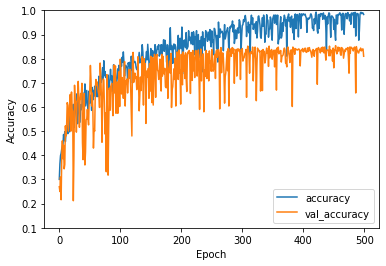

In [334]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

[[9.9920350e-01 2.3311983e-04 3.9997185e-06 3.8019798e-04 1.7926378e-04]]
prediction: 0
true class:  0


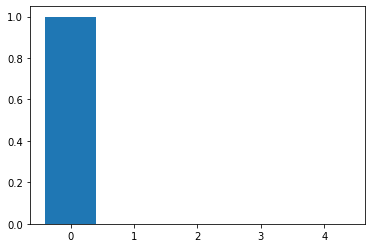

In [338]:
i = 3
prediction = new_model.predict(test_images[i].reshape(1,128,128))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

print("true class: ",np.argmax(test_labels[i]))
# draw the barplot
plt.figure()
plt.bar(np.arange(0,5).astype('str'), prediction[0])
plt.show()

# Training the Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
#--
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
#--
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
model.summary()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
es = EarlyStopping(monitor='val_loss',  verbose=1, patience=10)

In [ ]:
#history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
history = model.fit(x_train,y_train, batch_size = 32 ,epochs = 15 , validation_data = (x_val, y_val),callbacks = [learning_rate_reduction])

Epoch 1/15
125/125 [==============================] - 8s 56ms/step - loss: 0.6388 - accuracy: 0.7790 - val_loss: 3.3074 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - 6s 52ms/step - loss: 0.2584 - accuracy: 0.9100 - val_loss: 0.8859 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 3/15
125/125 [==============================] - 6s 52ms/step - loss: 0.1615 - accuracy: 0.9517 - val_loss: 0.4847 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 4/15
125/125 [==============================] - 7s 52ms/step - loss: 0.1209 - accuracy: 0.9620 - val_loss: 1.1934 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 5/15
125/125 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9595
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
125/125 [==============================] - 6s 52ms/step - loss: 0.1256 - accuracy: 0.9595 - val_loss: 0.4614 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 6/15
125/125 [==============================] - 6

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

16/16 [==============================] - 0s 22ms/step - loss: 0.1733 - accuracy: 0.9600
Loss of the model is -  0.17330273985862732
16/16 [==============================] - 0s 20ms/step - loss: 0.1733 - accuracy: 0.9600
Accuracy of the model is -  95.99999785423279 %


# Analysis after Model Training

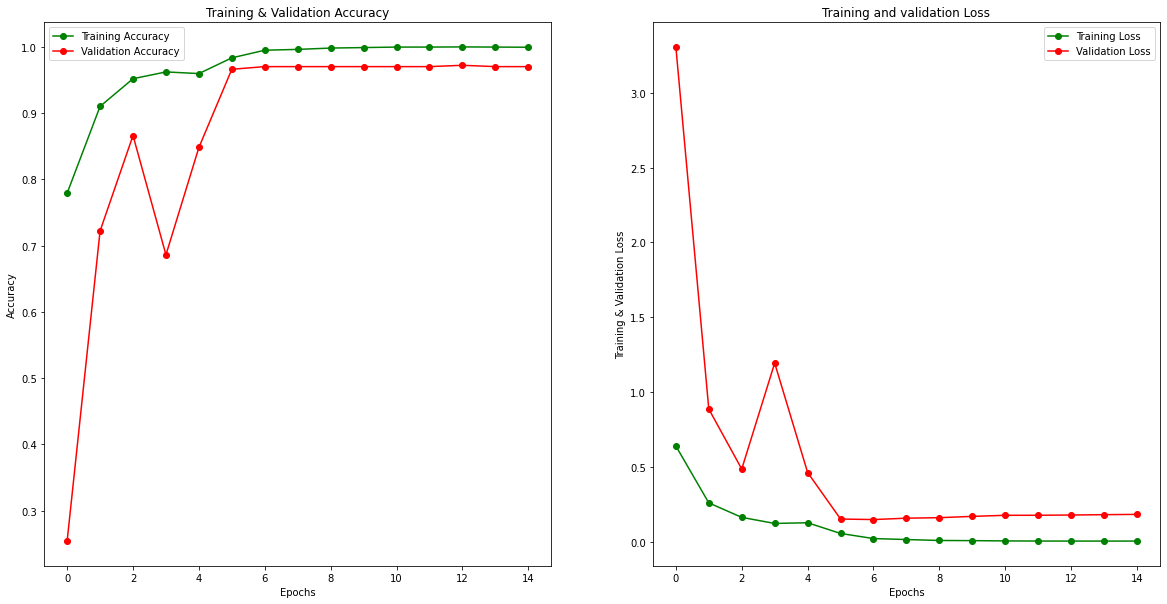

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training and validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report


ypredict_test_vectors = model.predict(x_test)
ypredict_test = np.argmax(ypredict_test_vectors,axis=1)

In [ ]:
cm = confusion_matrix(y_test,ypredict_test)
cm

array([[100,   8,   0,   0,   0],
       [  6,  86,   1,   0,   1],
       [  0,   0,  96,   0,   0],
       [  0,   3,   0, 104,   0],
       [  0,   1,   0,   0,  94]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1','2','3','4'] , columns = ['0','1','2','3','4'])

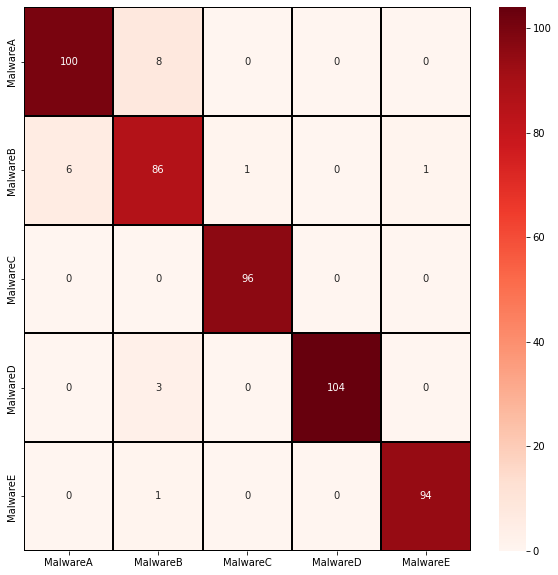

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(y_test,ypredict_test))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       108
           1       0.88      0.91      0.90        94
           2       0.99      1.00      0.99        96
           3       1.00      0.97      0.99       107
           4       0.99      0.99      0.99        95

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [ ]:
#PR curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve

y_score = model.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)


NameError: ignored

In [ ]:
#Roc Curve
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Code to generate the test file


In [ ]:

img_size = 128
def get_training_data_2_electric_boogaloo(data_dir):
    X = [] 
    fileName = []
    path = data_dir
    for img in os.listdir(path):
        try:
            fileName.append(img)
            img_arr = pd.read_csv(os.path.join(path, img), header=None, index_col=None).to_numpy()
            X.append(img_arr)
        except Exception as e:
            print(e)
    return np.array(X),np.array(fileName)

In [ ]:
x_final_test,fileNames = get_training_data_2_electric_boogaloo("/content/drive/MyDrive/ColabNotebooks/Cs271/CS_271_Final_Output_Images/test")

In [ ]:
x_final_test.shape

(500, 128, 128)

In [ ]:
fileNames.shape

(500,)

In [ ]:
y_finals_predict_vector = model.predict(x_final_test)

In [ ]:
y_finals_predict_vector.shape

(500, 5)

In [ ]:
y_finals_predict = np.argmax(y_finals_predict_vector,axis=1)

In [ ]:
y_finals_predict.shape

(500,)

In [ ]:
y_finals_predict

array([1, 2, 0, 1, 3, 3, 1, 4, 1, 3, 2, 3, 4, 0, 0, 1, 1, 1, 4, 2, 2, 4,
       2, 4, 0, 0, 2, 0, 1, 1, 3, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2,
       0, 4, 1, 0, 0, 4, 4, 1, 4, 3, 4, 2, 4, 0, 3, 2, 3, 1, 2, 0, 3, 0,
       1, 3, 1, 0, 0, 2, 3, 0, 4, 1, 4, 2, 0, 2, 3, 2, 1, 1, 0, 3, 4, 1,
       4, 3, 1, 3, 3, 3, 1, 0, 2, 2, 3, 1, 0, 0, 1, 2, 4, 1, 2, 1, 4, 0,
       3, 3, 0, 0, 1, 2, 3, 2, 3, 3, 1, 4, 1, 4, 1, 0, 2, 3, 3, 2, 2, 4,
       4, 1, 3, 3, 0, 1, 3, 1, 3, 3, 1, 4, 4, 4, 1, 1, 3, 1, 4, 4, 1, 3,
       0, 1, 2, 2, 1, 2, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 4, 1, 1, 4, 4, 3,
       0, 1, 0, 2, 4, 1, 0, 4, 4, 4, 2, 1, 4, 1, 1, 2, 1, 2, 2, 1, 0, 2,
       0, 1, 0, 2, 3, 1, 1, 2, 0, 3, 1, 4, 3, 4, 3, 4, 3, 4, 0, 3, 2, 3,
       1, 3, 4, 3, 1, 0, 3, 4, 4, 0, 3, 4, 4, 4, 4, 3, 0, 2, 0, 0, 4, 4,
       0, 4, 1, 1, 2, 3, 1, 4, 0, 4, 0, 1, 0, 3, 0, 2, 2, 4, 1, 3, 3, 3,
       2, 3, 2, 0, 0, 0, 2, 4, 1, 2, 2, 1, 3, 3, 2, 0, 1, 3, 3, 3, 4, 3,
       3, 2, 0, 3, 0, 1, 1, 4, 1, 2, 1, 0, 3, 1, 2,

In [ ]:
import csv
f = open('CNN_results.csv', 'w')
writer = csv.writer(f)

for i in range(500):
    col1 = fileNames[i]
    if(y_finals_predict[i] == 0):
      col2 = 'A'
    if(y_finals_predict[i] == 1):
      col2 = 'B'
    if(y_finals_predict[i] == 2):
      col2 = 'C'
    if(y_finals_predict[i] == 3):
      col2 = 'D'
    if(y_finals_predict[i] == 4):
      col2 = 'E'
    writer.writerow([col1, col2])

f.close()
